In [1]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [0]:
import matplotlib
matplotlib.rcParams.update({'font.size': 16})

In [0]:
import pickle
import warnings
warnings.filterwarnings('ignore')

training_file = 'dataset/train.p'
validation_file= 'dataset/valid.p'
testing_file = 'dataset/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

In [0]:
import pandas as pd
import numpy as np

In [0]:
signnames = pd.read_csv('signnames.csv')
signnames.set_index('ClassId',inplace=True)

def get_name_from_label(label):
    # Helper, transofrm a numeric label into the corresponding strring
    return signnames.loc[label].SignName

In [6]:

# Number of training examples
n_train = X_train.shape[0]

# Number of testing examples.
n_test = X_test.shape[0]

# Number of testing examples.
n_valid = X_valid.shape[0]

# What's the shape of an traffic sign image?
image_shape = X_train.shape[1:]

# How many unique classes/labels there are in the dataset.
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of validation examples =", n_valid)

print("Number of testing examples =", n_test)

print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
%matplotlib inline

In [8]:
counter = Counter(y_train)
print("Train example per class mean {} min {} max {}".format(int(np.mean(list(Counter(y_train).values()))),
                                                    np.min(list(Counter(y_train).values())) ,
                                                    np.max(list(Counter(y_train).values())) ))
print()
print("Most common signs:")
for el in counter.most_common(10):
    print("'{}'".format(get_name_from_label(el[0])),' train samples: {}'.format(el[1]))
print()
print("Most rare signs:")
for el in sorted(counter.items(),key=lambda x: x[1])[:10]:
    print("'{}'".format(get_name_from_label(el[0])),' train samples: {}'.format(el[1]))

Train example per class mean 809 min 180 max 2010

Most common signs:
'Speed limit (50km/h)'  train samples: 2010
'Speed limit (30km/h)'  train samples: 1980
'Yield'  train samples: 1920
'Priority road'  train samples: 1890
'Keep right'  train samples: 1860
'No passing for vehicles over 3.5 metric tons'  train samples: 1800
'Speed limit (70km/h)'  train samples: 1770
'Speed limit (80km/h)'  train samples: 1650
'Road work'  train samples: 1350
'No passing'  train samples: 1320

Most rare signs:
'Go straight or left'  train samples: 180
'Dangerous curve to the left'  train samples: 180
'Speed limit (20km/h)'  train samples: 180
'End of no passing'  train samples: 210
'End of no passing by vehicles over 3.5 metric tons'  train samples: 210
'End of all speed and passing limits'  train samples: 210
'Pedestrians'  train samples: 210
'Bicycles crossing'  train samples: 240
'Road narrows on the right'  train samples: 240
'Keep left'  train samples: 270


In [0]:
counts = pd.DataFrame(columns=['sign_label','training_samples_count'],data=[(label, count) for label, count in counter.items()])
counts['sign'] = counts.sign_label.apply(get_name_from_label)

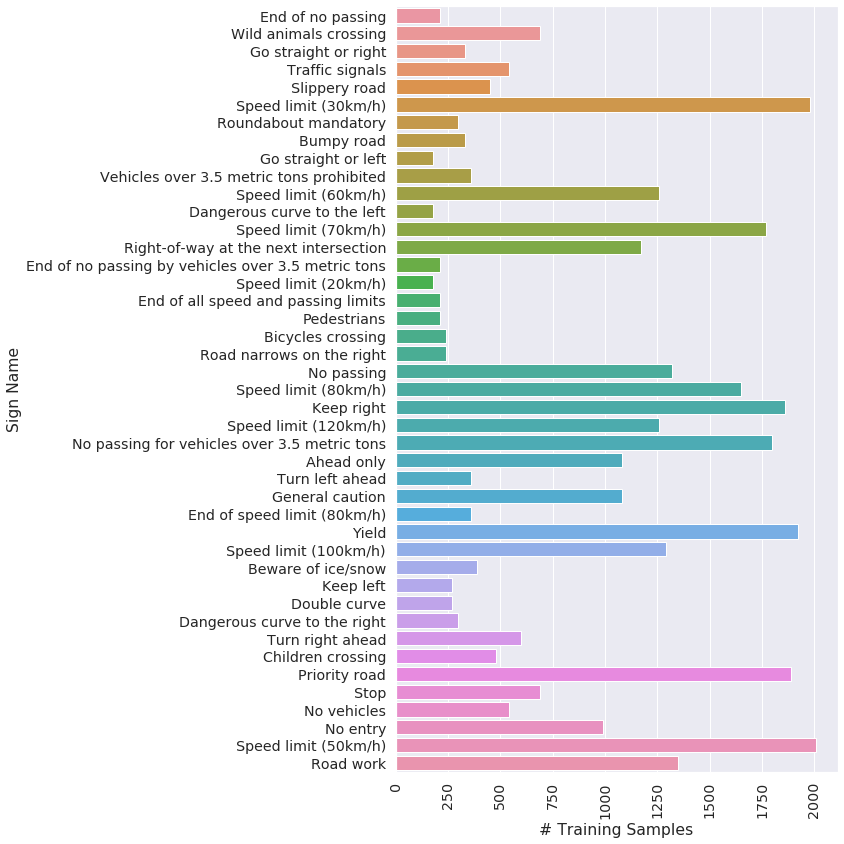

In [10]:
plt.figure(figsize=(12,12))
sns.set(font_scale=1.3)
sns.barplot(x='training_samples_count',y='sign',data=counts,orient='o')
plt.xticks(rotation=90)
plt.ylabel('Sign Name')
plt.xlabel('# Training Samples');
plt.tight_layout()
plt.savefig('plots/training_set_counts.png')

In [0]:
def get_random_samples(n_max=1):
    selected = list()
    
    for current_label in range(43):
        found=0
        while found<n_max:
            ii = np.random.randint(len(y_train))
            
            if current_label == y_train[ii]:
                selected.append(ii)
                found+=1


    assert len(selected) ==  43*n_max
    return list(selected)

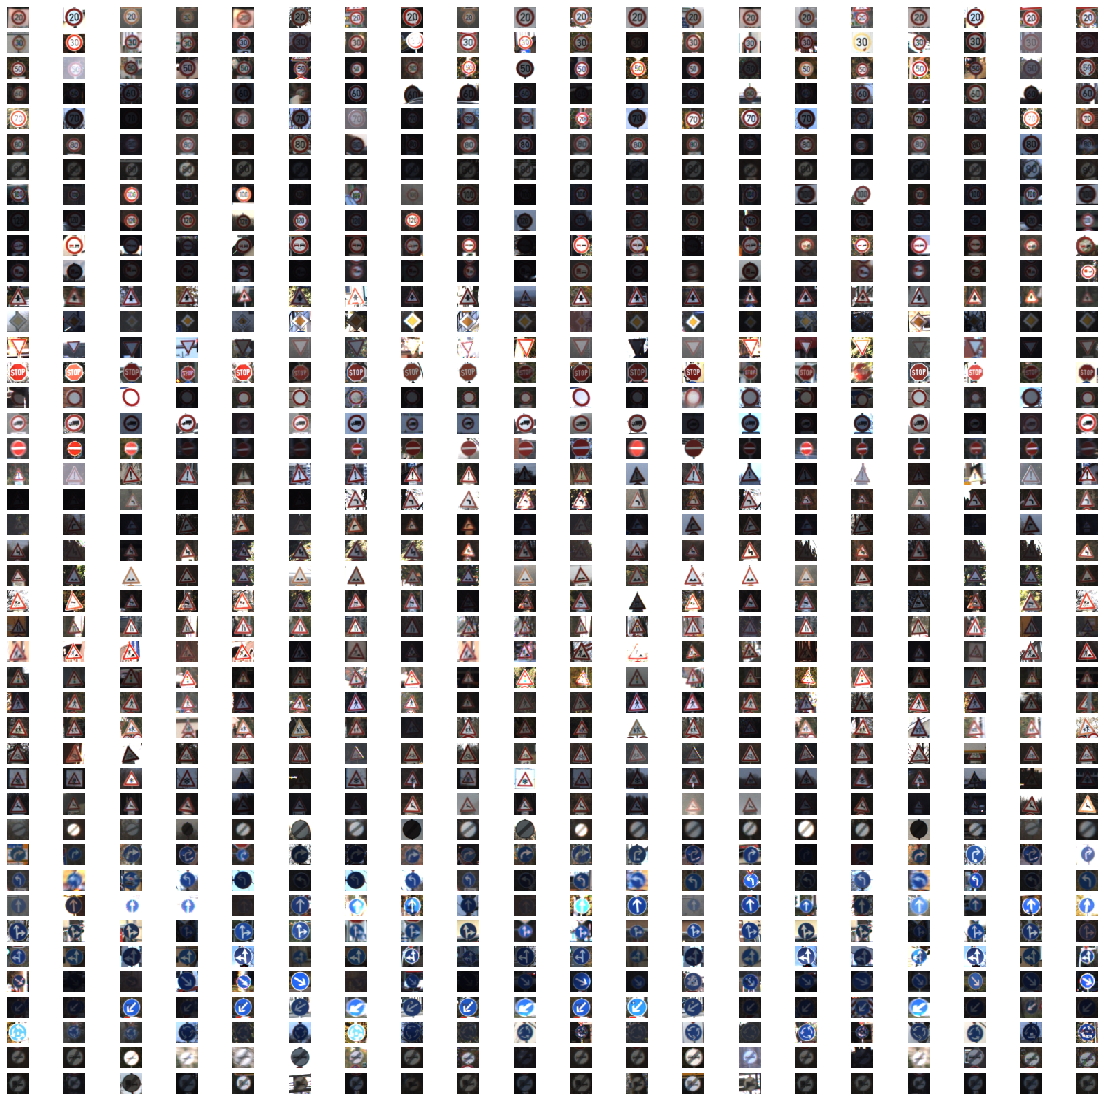

In [13]:
plt.figure(figsize=(20,20))
count=0
cols = 20
for ii in get_random_samples(cols):
    count+=1
    plt.subplot(43,cols,count)
    plt.imshow(X_train[ii])
    plt.axis('off')
# plt.tight_layout()
plt.savefig('plots/random_examples.png',bbox_inches='tight')

In [0]:
import cv2

In [0]:
img_size = 32

def sharpen_img(img):
    gb = cv2.GaussianBlur(img, (5,5), 20.0)
    return cv2.addWeighted(img, 2, gb, -1, 0)

def transform_img(img_in):
    img_in = img_in.copy()
    img_out= sharpen_img(img_in)
    img_out = cv2.cvtColor(img_in, cv2.COLOR_RGB2YUV)

    img_out[:,:,0] = cv2.equalizeHist(img_out[:,:,0])
#     img_out[:,:,1] = cv2.equalizeHist(img_out[:,:,1])
#     img_out[:,:,2] = cv2.equalizeHist(img_out[:,:,2])
    
    return img_out[:,:,0]

def random_rotate_img(img):
    c_x,c_y = int(img.shape[0]/2), int(img.shape[1]/2)
    ang = 30.0*np.random.rand()-15
    Mat = cv2.getRotationMatrix2D((c_x, c_y), ang, 1.0)
    return cv2.warpAffine(img, Mat, img.shape[:2])

def random_scale_img(img):
    img2=img.copy()
    sc_y=0.4*np.random.rand()+1.0
    img2=cv2.resize(img, None, fx=1, fy=sc_y, interpolation = cv2.INTER_CUBIC)
    
    dy = int((img2.shape[1]-img.shape[0])/2)
    end = img.shape[1]-dy
    img2 = img2[dy:end,:,:]
    assert img2.shape[0] == 32
#     print(img2.shape,dy,end)
    return img2

#Compute linear image transformation ing*s+m
def lin_img(img,s=1.0,m=0.0):
    img2=cv2.multiply(img, np.array([s]))
    return cv2.add(img2, np.array([m]))

#Change image contrast; s>1 - increase
def contr_img(img, s=1.0):
    m=127.0*(1.0-s)
    return lin_img(img, s, m)


def augment_img(img):
    img = img.copy()
    img=contr_img(img, 1.8*np.random.rand()+0.2)
    img=random_rotate_img(img)
    img=random_scale_img(img)

    return transform_img(img)

(32, 32)


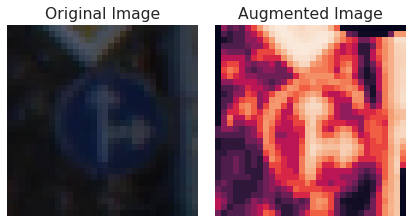

In [16]:

img = X_train[1000]
plt.subplot(1,2,1)
plt.imshow(img)
plt.title('Original Image')
plt.axis('off')
plt.subplot(1,2,2)
plt.axis('off')
out = augment_img(img)
print(out.shape)
plt.imshow(out)
plt.title('Augmented Image')
plt.tight_layout()
plt.savefig('plots/augmented_img_example.png',bbox_inches='tight')

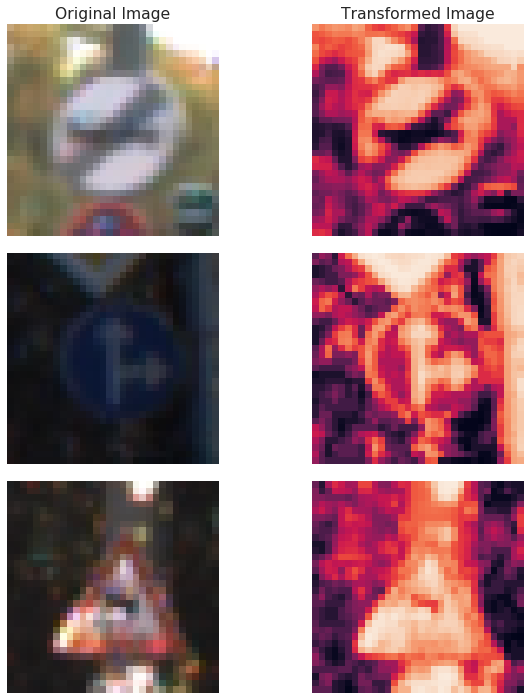

In [17]:
plt.figure(figsize=(10,10))
img = X_train[100]
plt.subplot(3,2,1)
plt.imshow(img)
plt.title('Original Image')
plt.axis('off')
plt.subplot(3,2,2)
plt.axis('off')
plt.imshow(transform_img(img))
plt.title('Transformed Image')


img = X_train[1000]
plt.subplot(3,2,3)
plt.imshow(img)
plt.axis('off')
plt.subplot(3,2,4)
plt.axis('off')
plt.imshow(transform_img(img))

img = X_train[2190]
plt.subplot(3,2,5)
plt.imshow(img)

plt.axis('off')
plt.subplot(3,2,6)
plt.axis('off')
plt.imshow(transform_img(img))
plt.tight_layout()
plt.savefig('plots/image_transformations.png',bbox_inches='tight')

In [0]:

# Transform all images and augment training datfa
X_train_transf = list()
y_train_transf = list()
X_test_transf = list()
X_valid_transf = list()
for ii in range(X_train.shape[0]):
    img = X_train[ii]
    label = y_train[ii]
    
    imgout = transform_img(img)
    imgout.shape = (1,) + imgout.shape + (1,)
    X_train_transf.append(imgout)
    y_train_transf.append(label)
    for j in range(50):
        imgout = augment_img(img)
        imgout.shape = (1,) + imgout.shape + (1,)
        X_train_transf.append(imgout)
        y_train_transf.append(label)
    

for ii in range(X_valid.shape[0]):
    img = X_valid[ii]
    img = transform_img(img)
    img.shape = (1,) + img.shape + (1,)
    X_valid_transf.append(img)
    
for ii in range(X_test.shape[0]):
    img = X_test[ii]
    img = transform_img(img)
    img.shape = (1,) + img.shape + (1,)
    X_test_transf.append(img)

X_test_transf = np.concatenate(X_test_transf,axis=0)
X_train_transf = np.concatenate(X_train_transf,axis=0)
X_valid_transf = np.concatenate(X_valid_transf,axis=0)
y_train_transf = np.array(y_train_transf)

In [0]:
from tensorflow.contrib.layers import flatten

def LeNet(x):
    """
    Implement classic lenet architecture in tensorflow
    """
    mu = 0
    sigma = 0.1
    
    # Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    #  Activation.
    conv1 = tf.nn.relu(conv1)

    # Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    #  Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    #  Activation.
    conv2 = tf.nn.relu(conv2)

    # Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SFlatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)
    
    # Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    #  Activation.
    fc1    = tf.nn.relu(fc1)
    
    dr1 = tf.nn.dropout(fc1, keep_prob) 
    
    # Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(dr1, fc2_W) + fc2_b
    
    # Activation.
    fc2    = tf.nn.relu(fc2)
    
    
    dr2 = tf.nn.dropout(fc2, keep_prob) 
    
    #  Layer 5: Fully Connected. Input = 84. Output = 10.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(dr2, fc3_W) + fc3_b
    
    return logits

In [0]:

x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
keep_prob = tf.placeholder(tf.float32)
one_hot_y = tf.one_hot(y, 43)

In [22]:
rate = 0.0001

logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits = logits, labels = one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)
predict_operation = tf.argmax(logits, 1)
predict_proba_operation = tf.nn.softmax(logits=logits)

Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [0]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples


def predict(X_data):
    num_examples = len(X_data)
    sess = tf.get_default_session()
    predicted_proba = list()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x = X_data[offset:offset+BATCH_SIZE]
        predicted_proba.extend( sess.run(predict_proba_operation, feed_dict={x: batch_x, keep_prob: 1.0}))
        
        
    return predicted_proba

In [0]:
X_train = X_train_transf
X_valid = X_valid_transf
X_test = X_test_transf
y_train = y_train_transf

In [0]:
from sklearn.utils import shuffle
from time import time

In [0]:

#Do some logging
import logging, datetime
logger = logging.getLogger()

def setup_file_logger(log_file):
    hdlr = logging.FileHandler(log_file)
    formatter = logging.Formatter('%(asctime)s %(levelname)s %(message)s')
    hdlr.setFormatter(formatter)
    logger.addHandler(hdlr) 
    logger.setLevel(logging.INFO)

def log(message):
    #outputs to Jupyter console
    print('{} {}'.format(datetime.datetime.now(), message))
    #outputs to file
    logger.info(message)

setup_file_logger('training.log')

In [27]:
EPOCHS = 150
BATCH_SIZE = 128
dropout = .3

errors = list()

saver = tf.train.Saver()
start = time()
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    log("Training... dropout = {} , batch_size = {} , learning rate = {}".format(dropout, BATCH_SIZE, rate))
    print()
    for i in range(EPOCHS):
        try:
            X_train, y_train = shuffle(X_train, y_train)
            for offset in range(0, num_examples, BATCH_SIZE):
                end = offset + BATCH_SIZE
                batch_x, batch_y = X_train[offset:end], y_train[offset:end]
                sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1 - dropout})
            validation_accuracy = evaluate(X_valid, y_valid)
            training_accuracy = evaluate(X_train, y_train)
            
            errors.append((training_accuracy,validation_accuracy))
            log("EPOCH %d - %d sec ..."%(i+1, time() - start))
            log("Training error = {:.3f} Validation error = {:.3f}".format(1- training_accuracy, 1- validation_accuracy))
            print()
            if i > 5 and i % 3 == 0:
                saver.save(sess, 'models/lenet')
                print("Model saved %d sec"%(time() - start))
        except KeyboardInterrupt:
            print('Accuracy Model On Test Images: {}'.format(evaluate(X_test,y_test)))   
            break
    saver.save(sess, 'models/lenet')

2020-02-24 18:10:58.917209 Training... dropout = 0.3 , batch_size = 128 , learning rate = 0.0001

2020-02-24 18:12:07.553003 EPOCH 1 - 74 sec ...
2020-02-24 18:12:07.553514 Training error = 0.276 Validation error = 0.379

2020-02-24 18:13:12.272926 EPOCH 2 - 139 sec ...
2020-02-24 18:13:12.273531 Training error = 0.149 Validation error = 0.219

2020-02-24 18:14:14.787966 EPOCH 3 - 202 sec ...
2020-02-24 18:14:14.788316 Training error = 0.106 Validation error = 0.156

2020-02-24 18:15:17.702438 EPOCH 4 - 264 sec ...
2020-02-24 18:15:17.703057 Training error = 0.084 Validation error = 0.125

2020-02-24 18:16:21.538067 EPOCH 5 - 328 sec ...
2020-02-24 18:16:21.538491 Training error = 0.076 Validation error = 0.102

2020-02-24 18:17:24.365614 EPOCH 6 - 391 sec ...
2020-02-24 18:17:24.366350 Training error = 0.069 Validation error = 0.102

2020-02-24 18:18:26.480011 EPOCH 7 - 453 sec ...
2020-02-24 18:18:26.480744 Training error = 0.062 Validation error = 0.082

Model saved 453 sec
2020-02-

In [0]:
train_x = X_train.copy()
train_y = y_train.copy()
valid_x = X_valid.copy()
valid_y = y_valid.copy()
test_x = X_test.copy()
test_y = y_test.copy()

Text(0.5, 12.848000000000013, 'Epoch')

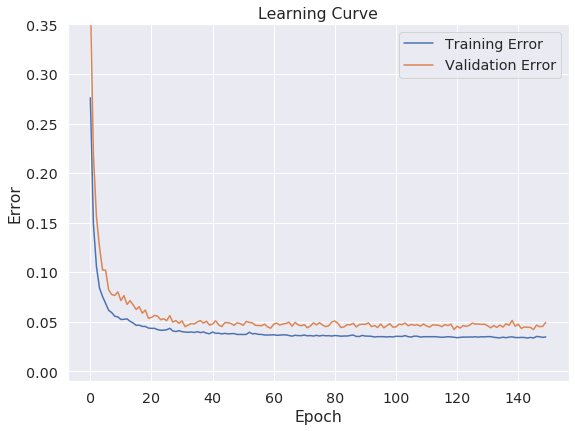

In [30]:
plt.figure(figsize=(8,6))
plt.title('Learning Curve')
plt.plot([1 - el[0] for el in errors])
plt.plot([1 - el[1] for el in errors])
plt.ylim([-.01,0.35])
plt.legend(['Training Error','Validation Error'])
plt.tight_layout()
plt.savefig('plots/learning_curve.png')
plt.ylabel('Error')
plt.xlabel('Epoch')

In [31]:
with tf.Session() as sess:
  saver.restore(sess, tf.train.latest_checkpoint('models'))
  print('Accuracy Model On Training Images: {:.2f}'.format(evaluate(train_x, train_y)))
  print('Accuracy Model On Validation Images: {:.2f}'.format(evaluate(valid_x, valid_y))) 
  print('Accuracy Model On Test Images: {:.2f}'.format(evaluate(test_x, test_y)))

INFO:tensorflow:Restoring parameters from models/lenet
Accuracy Model On Training Images: 0.97
Accuracy Model On Validation Images: 0.95
Accuracy Model On Test Images: 0.93


In [0]:
import skimage
from skimage import io
from skimage import transform
from skimage.filters import gaussian
import glob

more_images/image2.jpg
more_images/image4.jpg
more_images/image1.jpg
more_images/image3.jpg
more_images/image5.jpg


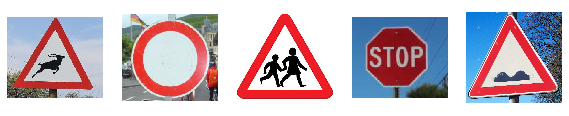

In [33]:
i=1
plt.figure(figsize=(12,10))
for el in glob.glob('more_images/*.png') + glob.glob('more_images/*.jpg'):
  print(el)
  img = io.imread(el)
  plt.subplot(1,6,i)
  plt.imshow(img)
  i+=1
  plt.axis('off')
  img = transform.resize(img,(32,32), order=3)
  img = gaussian(img,.4,multichannel=True)

In [34]:
plt.savefig('plots/new_images.png',bbox_inches='tight')

<Figure size 432x288 with 0 Axes>

In [0]:
i=1
images_wild = list()
labels_wild = list()
for line in open('more_images/data.txt','r'):
  fname, label = line.strip().split(' ')
  label = int(label)
  fname = 'more_images/'+fname
  img = io.imread(fname)
  img = transform.resize(img,(32,32), order=3)
  img = gaussian(img,.6,multichannel=True)*255
  img = transform_img(img.astype(np.uint8))
  img.shape = (1,) + img.shape + ( 1,)
  images_wild.append(img)
  labels_wild.append(label)

In [0]:
images = np.concatenate(images_wild,axis=0)

In [37]:
with tf.Session() as sess:
  saver.restore(sess, tf.train.latest_checkpoint('models'))
  predicted_proba = np.vstack(predict(images))
  print('Accuracy Model on new Images: {}'.format(evaluate(images, labels_wild)))

INFO:tensorflow:Restoring parameters from models/lenet
Accuracy Model on new Images: 0.800000011920929


In [38]:
# Getting Top 5 Softmax Probabilities for each new Image
for true_label,row in zip(labels_wild,predicted_proba):
  top5k = np.argsort(row)[::-1][:5]
  top5p = np.sort(row)[::-1][:5]
  print('Top 5 Labels for image \'{}\':'.format(get_name_from_label(true_label)))
  for k,p in zip(top5k,top5p):
    print(' - \'{}\' with prob = {:.2f} '.format(get_name_from_label(k),p))

Top 5 Labels for image 'Children crossing':
 - 'Children crossing' with prob = 0.80 
 - 'Go straight or right' with prob = 0.08 
 - 'End of no passing' with prob = 0.06 
 - 'Keep right' with prob = 0.04 
 - 'No passing' with prob = 0.01 
Top 5 Labels for image 'Wild animals crossing':
 - 'Children crossing' with prob = 1.00 
 - 'Keep right' with prob = 0.00 
 - 'Dangerous curve to the right' with prob = 0.00 
 - 'Go straight or right' with prob = 0.00 
 - 'Slippery road' with prob = 0.00 
Top 5 Labels for image 'Stop':
 - 'Stop' with prob = 1.00 
 - 'Priority road' with prob = 0.00 
 - 'Yield' with prob = 0.00 
 - 'Turn right ahead' with prob = 0.00 
 - 'No entry' with prob = 0.00 
Top 5 Labels for image 'No vehicles':
 - 'No vehicles' with prob = 1.00 
 - 'Speed limit (30km/h)' with prob = 0.00 
 - 'Speed limit (50km/h)' with prob = 0.00 
 - 'Speed limit (80km/h)' with prob = 0.00 
 - 'No passing' with prob = 0.00 
Top 5 Labels for image 'Bumpy road':
 - 'Bumpy road' with prob = 1.00 